In [67]:
import ccxt
import pandas as pd
from datetime import datetime, timedelta
import plotly.graph_objects as go
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import praw
import datetime
import time
import re
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from textblob import TextBlob
from collections import Counter

In [68]:
exchange = ccxt.binanceus()
markets = exchange.load_markets()
DOGE_markets = [market for market in markets if 'DOGE' in market]

DOGE_markets

['DOGE/USDT', 'DOGE/USD4', 'DOGE/BTC', 'DOGE/USD']

In [69]:
symbol = 'DOGE/USDT'
timeframe = '1h'
limit_per_request = 1000

In [70]:
start_date = datetime.datetime(2024, 8, 4, 19, 0)
end_date = datetime.datetime(2025, 1, 31, 18, 0)


start_timestamp = int(start_date.timestamp() * 1000)
end_timestamp = int(end_date.timestamp() * 1000)

all_ohlcv = []
current_timestamp = start_timestamp

while current_timestamp < end_timestamp:
    try:
        ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, since=current_timestamp, limit=limit_per_request)

        if not ohlcv:
            print(f"No more data available after {datetime.utcfromtimestamp(current_timestamp / 1000)}")
            break

        all_ohlcv.extend(ohlcv)


        current_timestamp = ohlcv[-1][0]


        exchange.sleep(1000)

    except Exception as e:
        print(f"Error fetching data: {e}")
        break


df = pd.DataFrame(all_ohlcv, columns=["timestamp", "open", "high", "low", "close", "volume"])

df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms")


df = df[(df["timestamp"] >= start_date) & (df["timestamp"] <= end_date)]

df = df.reset_index(drop=True)

df.index = range(len(df))


In [71]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df = df.drop_duplicates(subset=['timestamp'])
df = df.sort_values(by='timestamp').reset_index(drop=True)
df

,timestamp,open,high,low,close,volume
0,2024-08-04 19:00:00,0.10291,0.10538,0.10243,0.10484,33372.0
1,2024-08-04 20:00:00,0.10479,0.10592,0.10419,0.10504,176645.0
2,2024-08-04 21:00:00,0.10469,0.10500,0.10439,0.10448,153458.0
3,2024-08-04 22:00:00,0.10480,0.10575,0.10480,0.10529,14575.0
4,2024-08-04 23:00:00,0.10504,0.10504,0.10364,0.10366,24668.0
...,...,...,...,...,...,...
4315,2025-01-31 14:00:00,0.33698,0.33734,0.33097,0.33273,25940.0
4316,2025-01-31 15:00:00,0.33248,0.33926,0.33248,0.33926,714977.0
4317,2025-01-31 16:00:00,0.33845,0.33963,0.33624,0.33826,23147.0
4318,2025-01-31 17:00:00,0.33755,0.33756,0.33338,0.33338,52885.0


In [92]:
segments = {
    "Aug-Oct 2024": df[(df.index >= "2024-08-01") & (df.index < "2024-11-01")].copy(),
    "Nov-Jan 2025": df[(df.index >= "2024-11-01") & (df.index < "2025-02-01")].copy()
}

In [93]:
for key, df_seg in segments.items():
    df_seg["time"] = (df_seg.index - df_seg.index[0]).total_seconds() / (60 * 60)
    segments[key] = df_seg

In [94]:
def fit_lppl(df_segment):
    t_data = df_segment["time"].values
    p_data = df_segment["close"].values

    tc_guess = t_data[-1] + 100
    beta_guess = 0.5
    omega_guess = 10
    phi_guess = 0
    A_guess = np.mean(p_data)
    B_guess = -0.1 * A_guess
    C_guess = 0.1

    initial_params = [A_guess, B_guess, C_guess, tc_guess, beta_guess, omega_guess, phi_guess]

    bounds = ([0, -np.inf, -1, t_data[-1], 0, 0, -np.pi], [np.inf, np.inf, 1, t_data[-1] + 500, 1, 50, np.pi])

    opt_params, _ = curve_fit(lppl, t_data, p_data, p0=initial_params, bounds=bounds, maxfev=50000)

    return opt_params

In [95]:
lppl_fits = {}
for key, df_seg in segments.items():
    lppl_fits[key] = fit_lppl(df_seg)

In [97]:
lppl_crash_times = {key: pd.to_datetime(df_seg.index[0]) + pd.to_timedelta(tc_opt, unit="h") for key, (_, _, _, tc_opt, _, _, _) in lppl_fits.items()}
lppl_crash_times

{'Aug-Oct 2024': Timestamp('2025-01-28 16:01:08.192663482'),
 'Nov-Jan 2025': Timestamp('2025-02-16 11:13:03.921920601')}

In [98]:
lppl_hyperparams = {
    key: {
        "A (Baseline Price)": A_opt,
        "B (Bubble Growth Coeff)": B_opt,
        "C (Oscillation Strength)": C_opt,
        "t_c (Estimated Crash Time in hours)": tc_opt,
        "beta (Power Law Growth)": beta_opt,
        "omega (Oscillation Frequency)": omega_opt,
        "phi (Phase Shift)": phi_opt,
    }
    for key, (A_opt, B_opt, C_opt, tc_opt, beta_opt, omega_opt, phi_opt) in lppl_fits.items()
}

In [99]:
lppl_hyperparams_df = pd.DataFrame(lppl_hyperparams).T
lppl_hyperparams_df

,A (Baseline Price),B (Bubble Growth Coeff),C (Oscillation Strength),t_c (Estimated Crash Time in hours),beta (Power Law Growth),omega (Oscillation Frequency),phi (Phase Shift)
Aug-Oct 2024,76.618812,-76.392569,-0.000045,2128.018942,0.000223,9.681125,3.141593
Nov-Jan 2025,0.419222,-0.000052,1.000000,2579.217756,1.000000,6.621519,-2.494579


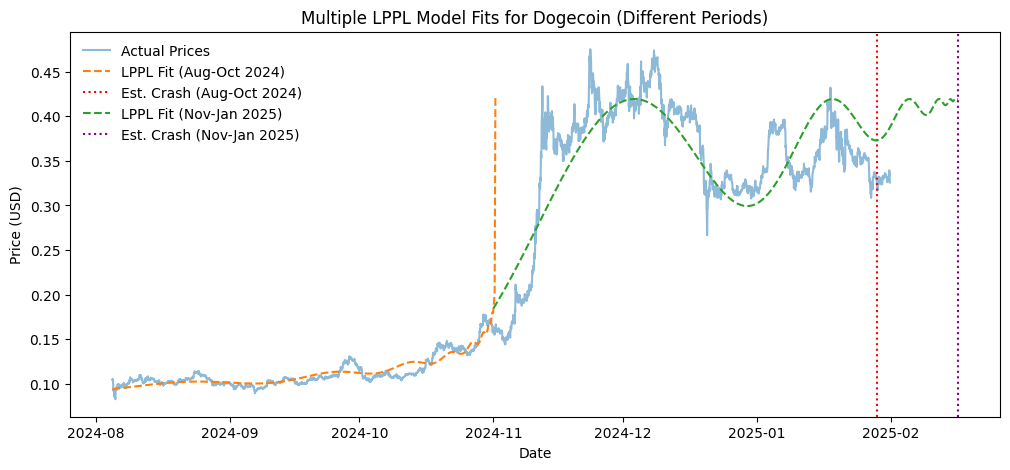

In [96]:
colors = ["red", "purple"]
color_cycle = iter(colors)

plt.figure(figsize=(12, 5), facecolor='none')

plt.plot(df.index, df["close"], label="Actual Prices", linewidth=1.5, alpha=0.5)

for key, (A_opt, B_opt, C_opt, tc_opt, beta_opt, omega_opt, phi_opt) in lppl_fits.items():
    df_seg = segments[key]
    t_fit = np.linspace(df_seg["time"].values[0], tc_opt - 1e-5, 500)
    p_fit = lppl(t_fit, A_opt, B_opt, C_opt, tc_opt, beta_opt, omega_opt, phi_opt)
    plt.plot(df_seg.index[0] + pd.to_timedelta(t_fit, unit="h"), p_fit, linestyle="dashed", label=f"LPPL Fit ({key})")

    plt.axvline(datetime.datetime(2024, 11, 1) + pd.to_timedelta(tc_opt, unit="h"), linestyle="dotted", color=next(color_cycle), label=f"Est. Crash ({key})")

plt.title("Multiple LPPL Model Fits for Dogecoin (Different Periods)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.gca().patch.set_alpha(0)
plt.gcf().patch.set_alpha(0)
legend = plt.legend(fontsize=10, loc='upper left', frameon=False)  # Remove legend frame
legend.get_frame().set_alpha(0)
plt.show()

In [100]:
def calculate_errors(df_segment, opt_params):
    t_data = df_segment["time"].values
    p_actual = df_segment["close"].values

    p_fitted = lppl(t_data, *opt_params)

    mae = mean_absolute_error(p_actual, p_fitted)
    mse = mean_squared_error(p_actual, p_fitted)
    rmse = np.sqrt(mse)

    return {"MAE": mae, "MSE": mse, "RMSE": rmse}

In [101]:
lppl_errors = {
    key: calculate_errors(segments[key], opt_params)
    for key, opt_params in lppl_fits.items()
}

In [102]:
lppl_errors_df = pd.DataFrame(lppl_errors).T
lppl_errors_df

,MAE,MSE,RMSE
Aug-Oct 2024,0.005676,0.000051,0.007121
Nov-Jan 2025,0.033049,0.001536,0.039191
